# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python  # install requirements

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")  # load environment

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]  # get the brain name
brain = env.brains[brain_name]   # store brain as variable

In [4]:
print(brain_name)
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

# Model
Simple Neural Network Model. Makes use of two hidden layers (size=64) between an input layer the same size as the State Space (37), and an output layer the same size as the Action Space (4).

Hidden layer connections are activated with a ReLU function.

Code credit: [Udacity Deep Reinforcement Learning](https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/model.py)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """DQN Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed (for repeatability)
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Agent
A simple DQN Agent, adapted from DeepMind's Nature paper: 
[Human-level control through deep reinforcement](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Code credit: [Udacity Deep Reinforcement Learning](https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py)

The Agent makes use of a Dual DQN network, with a local and a target network to improve stability.

The Agent explores the Action Space in an Epsilon Greedy manner. It learns to optimize actions which lead to greater rewards. 

Once a sufficient number of epoch memories have been accumilated, the Agent makes use of a Replay Buffer to learn again from a random sampling of past experiences in addition to current experiences.

In [8]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Apply Env to Agent

The agent is applied to the Banana environment.

We cap the agent at 500 episodes, and 1000 steps per episode. We run an epsilon-greedy strategy with epsilon decaying from 1.0 to a minimum of 0.01 with a decay of 0.96 per episode.

The environment is considered solved once the Agent is able to maintain an average score greater than 13 for 100 consecutive episodes. Our Agent is able to surpass a per-episode score greater than 13 within 100 episodes, and is able to achieve an average score greater than 13 this within 300 ~ 350 episodes.

We do not employ "early stopping" with our Agent, instead opting to run the full 500 episodes and see how our agent evolves beyond the solved configuration.

In [9]:
from collections import deque

def dqn(n_episodes=500, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.96):

    eps = eps_start
    max_score = 0                      # init a maximum score
    scores = []                        # keep track of all scores
    scores_window = deque(maxlen=100)  # last 100 scores

    agent = Agent(state_size=state_size, action_size=action_size, seed=0)  # init an Agent.
    
    for i in range(1, n_episodes+1): # episodes
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # set the initial state from env
        score = 0                                          # reset the score
        steps = max_t

        for t in range(max_t): # maximum steps per episode
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]              # send the action to the environment
            next_state = env_info.vector_observations[0]         # get the next state
            reward = env_info.rewards[0]                         # get the reward
            done = env_info.local_done[0]                        # see if episode has finished
            agent.step(state, action, reward, next_state, done)  # take the next step
            state = next_state                                   # set state to the next state
            score += reward                                      # update the score
            if done: 
                steps = t
                break 

        scores_window.append(score)        # save most recent score.
        scores.append(score)               # save most recent score.
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon

        # DEBUG INFO #
        
        # output a checkpoint if the agent is solved
        if np.mean(scores_window) > 13 and i % 50 == 0:
            print('\rAgent Solved:\t{:d}\tScore: {:.2f}\tAverage Score: {:.2f}\tMax Score: {:.2f}\tEpsilon: {:.2f}'.format(
                i, score, np.mean(scores_window), max_score, eps))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
            
        # output a checkpoint of the highest scoring episodes
        elif score > max_score and score > 13:
            print('\rHigh Score:\t{:d}\tScore: {:.2f}\tAverage Score: {:.2f}\tMax Score: {:.2f}\t Epsilon: {:.2f}'.format(
                i, score, np.mean(scores_window), max_score, eps))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pt')

        # print the episode score and keep it. save the model.
        elif i % 50 == 0:
            print('\rEpisode:\t{}\tScore: {:.2f}\tAverage Score: {:.2f}\tMax Score: {:.2f}\t Epsilon: {:.2f}'.format(
                i, score, np.mean(scores_window), max_score, eps))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pt')

        # print the episode score.
        else:
            print('\rEpisode:\t{}\tScore: {:.2f}\tAverage Score: {:.2f}\tMax Score: {:.2f}\t Epsilon: {:.2f}'.format(
                i, score, np.mean(scores_window), max_score, eps), end="")

        # FINAL UPDATES
        max_score = max(max_score, score)  # keep track of the maximum score.

    return scores

# Run Agent

In [10]:
scores = dqn()

Episode:	50	Score: 6.00	Average Score: 2.12	Max Score: 10.00	 Epsilon: 0.136
High Score:	94	Score: 14.00	Average Score: 4.40	Max Score: 13.00	 Epsilon: 0.02
Episode:	100	Score: 8.00	Average Score: 4.46	Max Score: 14.00	 Epsilon: 0.02
High Score:	110	Score: 18.00	Average Score: 5.21	Max Score: 14.00	 Epsilon: 0.01
High Score:	130	Score: 19.00	Average Score: 6.76	Max Score: 18.00	 Epsilon: 0.01
Episode:	150	Score: 12.00	Average Score: 7.16	Max Score: 19.00	 Epsilon: 0.01
Episode:	200	Score: 13.00	Average Score: 8.50	Max Score: 19.00	 Epsilon: 0.01
High Score:	250	Score: 20.00	Average Score: 10.40	Max Score: 19.00	 Epsilon: 0.01
High Score:	261	Score: 21.00	Average Score: 11.12	Max Score: 20.00	 Epsilon: 0.01
High Score:	265	Score: 23.00	Average Score: 11.47	Max Score: 21.00	 Epsilon: 0.01
Episode:	300	Score: 10.00	Average Score: 12.40	Max Score: 23.00	 Epsilon: 0.01
Agent Solved:	350	Score: 11.00	Average Score: 13.20	Max Score: 23.00	Epsilon: 0.01
High Score:	371	Score: 25.00	Average Sco

# Plot Data

Observe Agent score per episode.

We expect per episode rewards to be erratic, but generally trending upwards.

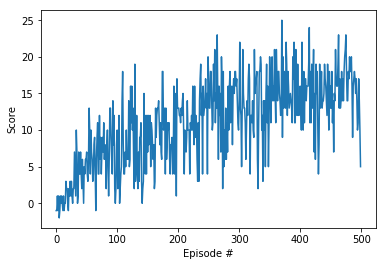

In [11]:
%matplotlib inline
# plot the scores
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Finished
When finished, you can close the environment.

In [12]:
env.close()